<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# RBM Deep Dive with Tensorflow 

- jupyter notebook에서는 추천 시스템에 대한 응용 프로그램과 함께 제한된 볼츠만 컴퓨터 (RBM) 알고리즘의 전체 연습을 제공합니다. 
- 특히, 우리는 1에서 5까지의 등급으로 영화 순위를 구성하는 이터 세트를 사례 연구로 사용합니다.

[towards data science 참고자료](https://towardsdatascience.com/deep-learning-meets-physics-restricted-boltzmann-machines-part-i-6df5c4918c15)


### 개요
- Restricted Boltzmann Machine (RBM)은 일반적으로 unsupervised learning을 수행하는 데 사용되는 generative neural network 모델입니다. 
- RBM의 주된 임무는 joint 확률 분포 𝑃 (𝑣, ℎ)를 배우는 것입니다. 여기서 𝑣는 보이는 단위이고 ℎ는 숨겨진 단위입니다. 숨겨진 유닛은 latent 변수를 나타내지만 보이는 유닛은 입력 데이터에 조인됩니다.  joint distribution가 학습되면 샘플링을 통해 새로운 예제가 생성됩니다.

- 여기서 제시된 구현은 Ruslan Salakhutdinov, Andriy Mnih 및 Geoffrey Hinton이 공동으로 필터링을 제한한 Boltzmann 시스템을 기반으로 함. 단, 논문에서 사용된 one-hot 인코딩 대신 multinomial units를 사용함


### Advantages of RBM: 

- 모델은 협업 필터링 기반 접근 방식을 사용하여 사용자 / 영화 쌍에 대한 등급을 생성합니다. 행렬 인수분해 방법은 User / Item affinity matrix(유사도 매트릭스)의 인스턴스를 재현하는 방법을 배우는 반면, RBM은 기본 확률 분포를 배웁니다. 여기에는 몇 가지 장점이 있습니다.

- 일반화 가능성
    - 모델은 확률이 크게 다르지 않은 한 새로운 예제로 일반화됨
- 시간의 안정성
    - 추천 작업이 시간 고정인 경우 모델은 새로운 등급 / 사용자를 수용하기 위해 자주 훈련할 필요가 없음

- 여기에 제시된 텐서플로우 구현을 통해 GPU에 대한 빠르고 확장 가능한 훈련을 허용

#### 1. RBM 이론
#### 2. 텐서플로우 구현 및 모델 매개변수
#### 3. 데이터 준비 및 검사
#### 4. 모델 응용, 성능 및 분석

- 섹션 1절과 2절은 선형 대수학, 확률 이론 및 텐서 플로우에 대한 기본 지식이 필요합니다.
- 섹션 3절과 4절은 기본적인 데이터 과학 이해만 필요로 함. 당신이 가장 관심 있는 구역으로 뛰어가도 좋다!

## 0 Global Settings and Import

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill 

#RBM 
from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.dataset.sparse import AffinityMatrix

#Evaluation libraries
from reco_utils.dataset import movielens 

from reco_utils.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)

from reco_utils.evaluation.parameter_sweep import generate_param_grid
#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Pandas version: 0.23.4


## 1. RBM Theory 

## 1.1 Overview and main differences with other recommender algorithms

- 제한된 볼츠만 기계(RBM)는 원래 magnetic systems(자석식??)의 통계 역학(또는 물리학)을 연구하기 위해 고안된 undirected graphical model이다. 

![](https://cdn-images-1.medium.com/max/1600/1*_7GZ3WAtplfzE73AgB_NbA.png)

- 통계역학 (Statistical mechanics)은 엄청난 수의 구성 요소 (일반적으로 ~1023)로 구성된 복잡한 시스템에 대한 확률론적 설명을 제공합니다. 시스템의 특정 인스턴스를 보는 대신 SM의 목적은 일반적인 동작을 설명하는 것입니다. 

- 이 접근법은 가스, 액체, 복합 재료 (예 :. 반도체) 그리고 유명한 힉스 입자! ([힉스입자](https://terms.naver.com/entry.nhn?docId=1532312&cid=40942&categoryId=32245))


- 많은 양의 데이터를 처리하고 구성하도록 설계된 SM은 현대 학습 알고리즘에서 이상적인 응용 프로그램을 찾습니다. 
- 추천 시스템의 맥락에서 아이디어는 특정 인스턴스 대신 일반적인 사용자 동작을 배우는 것입니다. 
- 더 잘 이해하기 위해 추천시스템 문제의 가장 일반적인 설정을 고려하십시오. 일부 척도에 따라 n 항목을 평가하는 m 사용자가 있습니다 (예 : 1에서 5까지)
    - 온라인 쇼핑, 스트리밍 서비스 또는 의사결정 프로세스의 일반적인 시나리오에서 사용자는 제품의 하위 집합 l << m만 평가합니다.
    - 이 문제에 대한 행렬 표현을 만들면 사용자 / 항목 유사도 행렬 X를 얻습니다. 더 읽을 수 있는 테이블 형식에서 X는 다음과 같이 보입니다.


|  $X$   |$i_1$  |$i_2$  |$i_3$  |  ... |$i_m$  | 
|-----|-------|-------|-------|------|-------|
|$u_1$|5      |0      |2      |0 ... |1      |
|$u_2$|0      |0      |3      |4 ... |0      |
|...  |...    |...    |...    |...   |...    |
|$u_m$|3      |3      |0      |5...  |2      |

- 여기서 0은 등급이 매겨지지 않은 항목을 나타냅니다. 간단히 말해서 추천의 임무는 누락된 등급을 "채우는 것"
    - 이 문제에 대한 고전적인 접근 방식을 행렬 인수 분해라고합니다. 기본 아이디어는 사용자 및 항목 행렬로 분해하는 것 (f 잠재 요인수)
    - 영화의 장르, 음식 유형 등 ... 그리고 모델의 하이퍼 매개 변수입니다. 
    - 사용자 행렬 Q와 아이템 행렬 P를 학습함으로써 X (사용 가능한 데이터로 제공)의 특정 인스턴스를 재현하고 이 정보를 사용하여 누락된 행렬 요소를 채우려고 함


- RBM 접근법은 보다 일반적인 프로세스의 특정 realization (샘플)으로 X를 보는 것 (generative model)
    - 특정 X를 배우는 대신 X가 샘플링된 행렬 분포를 배우려고 함. 효과적으로, 우리는 *tastes* (i.e. latent factors) 의 전형적인 분포를 배웁니다 
    - 해당 정보를 사용하여 새로운 등급을 생성합니다. 해당 종류의 신경망 모델은 generative 모델이라고도 합니다. 
    - 다음의 예를 생각해보자. 특정 국가의 연령별 소득 분배를 가정하고, 나이 window를 수정하여 다양한 소득을 가진 가상 시민을 이 차이에서 추출해낼 수 있다.

## 1.2 Model 

- 모든 SM 모델의 central quantity은 볼츠만 분포입니다. 주어진 확률 공간에서 가장 편향된 확률 분포로 볼 수 있으며, 분포 공간에서 최대 엔트로피 원리를 사용하여 얻을 수 있습니다. 전형적인 형태는 다음과 같습니다 :
    - 볼츠만 분포의 중요한 점은 모든 입자들의 미시적인 계산이 없어도 거시적 통계적인 방법을 통해 전체의 추정 가능한 양을 계산할 수 있음
    - 에너지가 낮을수록 많은 입자들이 분포학 확률이 크다는 특징

$$P = \frac{1}{Z} \, e^{- \beta \, H},$$ 

- 입력이 있을 확률은 에너지(H)에 반비례. 에너지(H)를 학습하는 것이 목적. (어떤 기체가 그 공간에 온도로 있을 확률은 온도에서 나온 에너지에 반비례 - 이런것들이 볼츠만 해석으로 가능)

- Energy-Based Models (EBM)은 deep learning에서 입력과 은닉층과의 관계를 에너지로 표현하여 볼츠만 분포를 이용하는 방법. RBM은 EBM의 변형 (Restricted, visible 노드 간의 관계 없애고, hidden 노드 간의 관계를 없앤 꼴)

- Z는 파티션 함수로 알려진 정규화 상수(확률의 총합이 1을 맞추도록, 모든 x,h case에 해당하는 exp의 합)이며, 역 에너지 단위를 갖는 noise 매개 변수이고 H는 시스템의 해밀턴 또는 에너지 함수
- 모델 클래스는 컴퓨터 과학에 기반한 에너지라고도 함. 물리학에서 볼츠만 상수의 단위로 시스템의 역 온도이지만, H 내부에서 효과적으로 그것을 재조정하여 순수한 숫자가 되도록 함
    - 입력과 출력이 양의 상관관계가 있을수록 에너지가 작아짐 (입력이 -1일 때 은닉층 결과가 -1이면 에너지가 최소가 됨)

![](https://cdn-images-1.medium.com/max/1000/1*Iq2Tn7aLAegiIg4sfkSgGA.png)

- H는 일반적으로 v (visibles)와 h (hidden)라고 불리는 두 세트의 확률 벡터의 동작을 설명
    - 전자는 알고리즘 입력과 출력을 구성하며, 숨겨진 단위는 우리가 배우고 싶은 잠재적인 요소    
    
![rbm1](https://recodatasets.blob.core.windows.net/images/RBM1.png)

- moviellens 의 입력은 1에서 5까지의 등급으로 구성됨. 따라서 집합 = 1,2,3,4,5에서 값을 취하는 m visible 변수의 이산 구성 공간을 고려해야 한다. 
- 시스템의 전역 구성은 v = (v1,v2, ..., vm) mv에 의해 결정되며 등급이 매겨지지 않은 영화에 대해 0을 취함. 또한 hidden Unit를 지정해야 함
    - 모든 영화에 대한 평점이 visible 노드 (v1, v2, ..., vm)
    - 특정 단위가 활성인지 아닌지, hidden 노드, h = (h1,h2, ..., hn) h를 나타내는 임의의 이진 변수 h = 0,1로 취함 (각각의 원소들이 0 또는 1을 확률적으로 가지고 있다고 가정)
    - 숨겨진 단위는 영화 장르와 같은 속성을 설명할 수 있음. 예를 들어, 공상 과학 / 공포 영화가 주어지면 해당 속성을 설명하는 숨겨진 단위만 활성화되어야 함. 이러한 시스템에 대한 최소 모델은 다음 해밀턴에 의해 정의됩니다.

![](https://cdn-images-1.medium.com/max/1600/1*ZY4c980_7MfEMYTIi6jvTw.png)

$$H = - \sum_{i,j \in G} v_i \, w_{ij} \, h_j - \sum_{i=1}^m v_i \, a_i - \sum_{j=1}^n h_i \, b_i$$

- E(v,h) = H (RBM의 에너지 함수)
- 첫 번째 용어는 가시적인 단위와 숨겨진 단위 사이의 상관 관계를 포착하는 "interaction term"이며 다른 두 용어는 단위의 편향을 고려하여 "latent term"입니다. 

- 상관 행렬 $ w_ij $와 두 가지 편향 $ a_i $ 및 $ b_i $는 적절하게 정의된 비용 함수의 최소화로 고정될 학습 매개 변수입니다. 
- 비지도 학습 문제, 즉. 실제 출력이 없으므로 예측과 레이블이 지정된 데이터 사이의 에러 함수를 직접 최소화할 수 없습니다. 
    - 모든 SM 문제에서와 마찬가지로 최소화할 수 있는 적절한 quantity은 자유 에너지입니다 

$$ F =- \log Z =- \log \sum_{ v_i, h_i } P(v, h) $$.

- 확률 이론의 언어에서 위의 quantity 은 cumulant generating function(mgf 로그)입니다. 
- 자유 에너지를 평가하는 한 가지 방법은 [Markov-chain 몬테카를로 샘플링] 알고리즘을 Metropolis-Hasting과 같이 사용하는 것
- 깁슨 샘플링은 몬테 카를로보다 빠르다는 이점이 있습니다. candidate F를 발견하면 F를 최소화하여 학습 매개 변수를 수정, 다음 섹션에서 이 방법이 실제로 어떻게 작동하는지 살펴보자.

## 1.3 Learning Algorithm 

- Joint 확률 분포에서 직접 샘플링하는 대신, 조건부 분포를 평가할 수 있음

$$ P(v, h) = P(v|h) P(h) = P(h|v) P(v) $$ 

![](https://cdn-images-1.medium.com/max/1000/1*NxzVmlmv6KDqO2k77WnfnA.png)
![](https://cdn-images-1.medium.com/max/1000/1*yx_C_ItC8aCUYbHhCJQY5g.png)
![](https://cdn-images-1.medium.com/max/1000/1*6BMmNqK8H3a_BFSq5K3j-A.png)

![](https://image.slidesharecdn.com/rbmpresentation-160427115516/95/restricted-boltzman-machine-rbm-presentation-of-fundamental-theory-44-638.jpg?cb=1461758166)

- negative log likelihood를 구하는 과정의 두가지 텀이 positive 단계, negative 단계
- 여기서 두 번째 equality은 모델이 방향이 없거나, 물리적으로 평형을 이루고 있다는 사실에서 따릅니다. 깁스 샘플링은 기본적으로 positive 단계 및  negative 단계로 불리는 두 단계로 구성됩니다.
- Positive 단계? log를 취하면서 분자에 해당하는 것의 gradient (input node의 값들과 그로 인해 연결된 hidden node의 값이 1이 될 확률)
- Neagtive 단계? 분모인 Z의 gradient (샘플링을 통해 값 추정, 모델의 평균값과 같은 input 값과 그로 인해 연결된 hidden node의 값이 1이 될 확률)
- 최종적으로 구해지는 gradient 값은 positive term - negative term이 됨 (둘 차이만큼 보정해서 weight와 바이어스를 업데이트)


![](https://cdn-images-1.medium.com/max/1000/1*ZY4c980_7MfEMYTIi6jvTw.png)
![](https://cdn-images-1.medium.com/max/1000/1*De0RDPU_XRqT0BMAVE4vqA.png)
![](https://cdn-images-1.medium.com/max/1000/1*UMbNSJVSmAgqkVnQKA62yg.png)
![](http://deeplearning.net/tutorial/_images/math/71c8949ae03ee393109b8e5adc37c3c4a9aa1e35.png)


[참고 자료](https://www.slideshare.net/SeongwonHwang/restricted-boltzman-machine-rbm-presentation-of-fundamental-theory)

### Positive 

- 데이터에 Visible 단위를 수정하고 즉 입력 벡터 전체에서 j 번째 숨겨진 단위가 활성화 될 확률을 계산하십시오. 실제로는 생성 함수를 평가하는 것이 편리합니다.

$$ Z[v,b] = \prod_j \sum_{h_j = 0,1}  e^{(\sum_i w_{ij} v_i + b_j) h_j} = \prod_j \left( 1+  e^{\sum_i w_{ij} v_i + b_j} \right).$$

- 우리가 얻을 수 있는 바이어스와 관련하여 기울기를 취함

$$\frac{\partial}{\partial b_j}\log Z[v,b] =  \frac{1}{1+ e^{-(\sum_i w_{ij} v_i + b_j)}} = \sigma( \phi_j(v, b) ),$$

where $\phi_j(v,b) = \sum_i w_{ij} v_i + b_j $ and we have identified the logistic function $\sigma(.) \equiv P(h_j=1|v,b)$. 


### Negative 

- 숨겨진 단위의 표본 값을 사용하여 $ P (v_i = q | h) $ **, $ q = 1, ..., 5 $ 를 평가하십시오. 다항식에 의해 주어짐

$$ P(v_i = q |h,a) =  \prod_{v_i=1}^q e^{v_i (\sum_j w_{ij} \, h_j + a_i ) }/Z_q $$,

- 여기서 $ Z_q $는 $ q $ 결과에 대해 계산된 파티션 함수입니다.
- 마지막으로 위의 분포에서 $ v_i $의 값을 샘플링합니다. 분명히 새로운 $ v_i $는 적어도 훈련 시작 단계가 아닌 입력으로 사용한 키워드 일 필요는 없습니다. 
- 위의 단계는 $ k $ 번 반복되며, 여기서 $ k $는 일반적으로 주어진 프로토콜에 따라 학습 중에 증가합니다.
- 각각의 k-step 깁스 샘플링의 끝에서 $ k = 0 $ (주어진 v)와 k-steps 이후의 자유 에너지 간의 차이를 평가합니다

$$ \Delta F = F_0 - F_k, $$

and update the learning parameters $w_{ij}$, $b_i$ and $a_i$: 

$$ \frac{\partial}{\partial b_j} \Delta F = \frac{\partial}{\partial b_j} (\log Z_0[v,b] - \log Z_k[v,b]) = P_0(h_j=1|v,b) - P_k(h_j=1|v,b) $$

$$ \frac{\partial}{\partial w_{ij} } \Delta F = v_i \, P_0(v_i = q|h, a) - v_i P_k(v_i| h,a) \equiv \langle v_i\rangle_0 - \langle v_i \rangle_k. $$

- 과정은 각 훈련시기마다, 결국 $ \ Delta F = 0 $까지 반복된다. 즉, 학습된 분포는 경험적으로 정확하게 재현된다. 
- 이 의미에서 $ v_i $는 모델의 입력과 출력을 모두 제공합니다. $ w_ {ij} $에는 사용자 투표의 상관 관계에 대한 정보가 포함되어 있으므로 이 정보를 사용하여 학습된 marginal distribution에서 샘플링하여 보이지 않는 영화에 대한 등급을 생성 할 수 있습니다.

$$ \langle v_i \rangle = \sum_{v_i} v_i \, P(v) $$ 


![](http://deeplearning.net/tutorial/_images/math/aaf04e6e2c43def4c009e913bff8a44a6baffa65.png)

- 전체 워크 플로가 아래에 요약되어 있습니다.

![gibbs](https://recodatasets.blob.core.windows.net/images/Gsampling.png)


## 2. TensorFlow implemetation and model parameters 

- 해당 섹션에서는 알고리즘이 Tensorflow에서 구현되는 방법과 훈련 중에 사용자가 사용자 정의 할 수있는 매개 변수를 간략하게 설명합니다. 
- 또한 추천시스템 작업에서 RBM 모델을 교육 할 때 사용되는 몇 가지 모범 사례에 대해 설명합니다. 추가 기술 정보는 코드에서 직접 설명합니다.

- Tensorflow (TF)는 빠르고 효율적인 방법으로 딥러닝(DL) 모델을 개발하는 오픈소스 프레임 워크입니다. 
- DL 프레임 워크의 공통된 특성 중 하나는 autodifferentiation, 즉 여기에서 특히 유용할 그라디언트의 symbolic 평가입니다. 
- TF의 또 다른 이점은 계산 그래프에 정의 된 기호 연산의 생성 및 최적화로 CPU와 GPU 모두에서 빠르고 확장 가능한 배치입니다. 
- 불행히도 TF는 지도 학습 과제에 맞춰 만들어 졌으므로 비지도 학습 모델에 적용하려면 더 많은 작업이 필요합니다. 

- RBM 모델은 그래프를 작성하고 샘플링, 학습 및 추론을 수행하는 여러 가지 방법으로 클래스로 인스턴스화됩니다. 그래프의 골격은 클래스가 인스턴스화되는 순간에 작성됩니다. 필수 입력란 :

- `hidden_units` integer (Default =500) : number of hidden units
- `training_epoch`integer (Default = 20): number of training epochs 
- `minibatch_size`integer (Default = 100): size of the batch to be chosen at random at each training epoch 

The optional parameters are: 

- `keep_prob` : float (Default = 0.7) we use dropout regularization on the hidden units, so this parameter specifies the probability of keeping the connection to a hidden unit active. Dropout will affect specific matrix elements of $w_{ij}$, decreasing in this way the model's complexity and improving generalization. 

- `sampling_protocol` : Array (Default = $[50, 70, 80,90,100]$) percentage of the entire training epochs when the the k-sampling step is increased in an annealing fashion. In the default case, the first 50% of the training epochs are sampled with a single k-step. As training converges, the number of k-steps is increased by $1$ at each percentage.

- `debug`: Boolean (Default = False) if True, prints the output of some of the intermediate steps for inspection. 

- `with_metrics`: Boolean (Default= False) if True it evaluates, print and finally plot the mean squared root error per training epoch on the training set. At the end, it also evaluates and print the total model accuracy both on the training and test set. We suggest to switch it off only for benchmarking execution time.  

- `init_stdv`: float (Default = 0.1) standard deviation used to inititialize the correlation matrix. 

- `learning_rate`: float (Default = 0.004) init learning rate used in the optimization algorithm. Note that the optimizer uses a different, effective learning rate scaled to the batch size $\alpha$ = `learning_rate/minibatch_size`. 

- `display_epoch `: integer (Default = 10) the number of epochs after which the rmse error is printed out during the learning phase. 


- 선택 사항이지만 다른 추천 시스템을 위해 샘플링 _protocol 을 수정해야할 가능성이 있습니다. 새로운 데이터 세트를 훈련할 때 이를 염두에 두는 것이 좋습니다.

# 3 Data preparation and inspection 

- Movielens 데이터 세트는 사용 가능한 등급의 수를 나타내는 크기가 다릅니다. 사용자 및 등급 영화 수는 다른 데이터 세트에서 변경됩니다. 
- 이 데이터는 특정 사용자가 특정 항목을 평가한 시점을 나타내는 사용자 ID, item ID, ratings 및 timestamp를 포함하여 pandas 데이터 프레임에서 가져옵니다. 
- 마지막 기능은 명시적으로 포함될 수 있지만 여기에서는 고려되지 않습니다. 선택의 기본 가정은 사용자의 취향이 약한 시간에 의존한다는 것입니다. 

- 사용자의 취향은 일반적으로 일반적인 권장 시간 척도 (예 :. 시간/일). 결과적으로 우리가 배우고 싶은 joint 확률 분포는 시간에 따라 dependent하게 고려 될 수 있습니다. 
- 그럼에도 불구하고 타임 스탬프는 컨텍스트 변수로 사용될 수 있습니다. 주말에는 특정 영화를 추천하고 평일에는 다른 영화를 추천합니다.


- 아래는 먼저 pandas 데이터 프레임에 다른 movielens 데이터를 로드하고 사용자 / affinity 매트릭스가 어떻게 구축되고 train / test 세트가 어떻게 생성되는지 설명합니다. 
- 이 절차는 여기에서 고려된 모든 데이터 세트에 공통적이므로 1m 데이터 세트에 대해서만 자세히 설명합니다.

- 우리는 다양한 데이터 세트를 다운로드하는 것으로 시작합니다.

In [2]:
MOVIELENS_DATA_SIZE = '100k'

mldf_100k = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)

# Convert the float precision to 32-bit in order to reduce memory consumption 
mldf_100k.loc[:, 'rating'] = mldf_100k['rating'].astype(np.int32) 

mldf_100k.head()

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
MOVIELENS_DATA_SIZE = '1m'

mldf_1m = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)

# Convert the float precision to 32-bit in order to reduce memory consumption 
mldf_1m.loc[:, 'rating'] = mldf_1m['rating'].astype(np.int32) 

mldf_1m.head()

,userID,movieID,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 3.1 Split the data using the stratified splitter  

- 두 번째 단계로, 우리는 동일한 행렬 크기를 유지함으로써 데이터를 훈련 및 테스트 세트로 분할합니다. 분명히 두 행렬은 서로 다른 비율로 다른 등급을 포함합니다.

- 첫째, AffinityMatrix 클래스를 사용하여 섹션 1.1에 정의된 $ (m, n) $ 사용자 / affinity 매트릭스 $ X $를 생성합니다. 
- 희소성 비율을 반환. 예를 들어, 1m 데이터 세트의 경우 행렬 항목의 95%는 0입니다. 학습 과제에 대한 도전 과제를 나타냅니다. 데이터 포인트의 5%만으로 항목의 95%를 수정합니다.


- 둘째, numpy_stratified_split()을 이용해 X 데이터를 훈련 세트와 테스트 세트로 나눠라. 기본적으로 우리는 75%에서 25%의 비율을 선택합니다. - 분할 함수는 모든 사용자에 대해 등급 영화의 25%를 선택하고 새로운 테스트 매트릭스로 이동합니다. 데이터를 분할하는 이러한 방법은 로컬 (사용자 별)과 전 세계적으로 훈련 / 테스트 세트에서 등급 분포가 동일하게 유지되도록 합니다. 


### Train

|  $X_{tr}$   |$i_1$  |$i_2$  |$i_3$  |  $...$ |$i_n$  |    
|-----|-------|-------|-------|--------|-------|
|$u_1$|$0$    |$0$    |$2$    |$0...$  |$0$    |
|$u_2$|$0$    |$0$    |$3$    |$0...$  |$0$    |
|$...$|$...$  |$...$  |$...$  |$...$   |$...$  |
|$u_m$|$3$    |$0$    |$0$    |$0...$  |$2$    |


### Test 

| $X_{tst}$    |$i_1$  |$i_2$  |$i_3$  |  ... |$i_n$  | 
|-----|-------|-------|-------|------|-------|
|$u_1$|5      |0      |0      |0 ... |1      |
|$u_2$|0      |0      |0      |4 ... |0      |
|...  |...    |...    |...    |...   |...    |
|$u_m$|0      |3      |0      |5...  |0      |

- 훈련 및 테스트 행렬은 정확히 동일한 dimensions를 갖는다 (즉, 동일한 수의 사용자와 영화)이지만 다른 등급을 포함합니다. 모델을 훈련하면 추론 시간에 테스트 세트 사용자 벡터를 사용하여 등급에 대한 유추 값을 얻습니다.

In [4]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

In [8]:
#instantiate the splitter 
am1m = AffinityMatrix(DF = mldf_1m, **header)

#obtain the sparse matrix 
X1m = am1m.gen_affinity_matrix()

In [15]:
print(am1m.Nitems)

3706


In [17]:
print(am1m.Nusers)

6040


In [55]:
X1m.shape

(6040, 3706)

In [57]:
np.random.seed(42)  # set the random seed
test_cut = int((1 - 0.75) * 100)  # percentage of ratings to go in the test set
print(test_cut)

# initialize train and test set matrices
Xtr = X1m.copy()
Xtst = X1m.copy()

# find the number of rated movies per user
rated = np.sum(Xtr != 0, axis=1)

# for each user, cut down a test_size% for the test set
tst = np.around((rated * test_cut) / 100).astype(int)

25


In [65]:
(rated * test_cut) / 100

array([13.25, 32.25, 12.75, ...,  5.  , 30.75, 85.25])

In [69]:
np.sum(Xtr != 0, axis=1)

array([ 53, 129,  51, ...,  20, 123, 341])

In [71]:
tst

array([13, 32, 13, ...,  5, 31, 85])

In [75]:
idx = np.asarray(np.where(Xtr[1] != 0))[0].tolist()

In [77]:
idx_tst = np.random.choice(idx, tst[1], replace=False)

In [78]:
idx_tst

array([101,  86,  65,  77, 160, 102, 115, 151, 127,  72, 141,  73, 110,
        23, 143, 146,  82, 126, 139, 130,  64,  56, 165,  57, 170,  91,
       116, 124,  93,   0,  58,  88])

In [ ]:
for u in range(6040):
        # For each user obtain the index of rated movies
        idx = np.asarray(np.where(Xtr[u] != 0))[0].tolist()

        # extract a random subset of size n from the set of rated movies without repetition
        idx_tst = np.random.choice(idx, tst[u], replace=False)
        idx_train = list(set(idx).difference(set(idx_tst)))

        # change the selected rated movies to unrated in the train set
        Xtr[u, idx_tst] = 0
        # set the movies that appear already in the train set as 0
        Xtst[u, idx_train] = 0

- 다음으로, 위의 행렬을 훈련 데이터로 분할하고 테스트 세트 희소 행렬을 설정합니다

In [26]:
Xtr_1m, Xtst_1m = numpy_stratified_split(X1m)

In [27]:
Xtr_1m.shape

(6040, 3706)

In [29]:
Xtst_1m.shape

(6040, 3706)

In [32]:
Xtr_1m

array([[5, 3, 4, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [33]:
Xtst_1m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

- 스플리터 함수가 일정하게 유지되도록 테스트 / 훈련 매트릭스의 등급 분포를 검사하는 것이 유용합니다. 정규화된 히스토그램을 표시하여 이 점을 검사할 수 있습니다

[Text(0, 0.5, 'density'), Text(0.5, 0, 'ratings')]

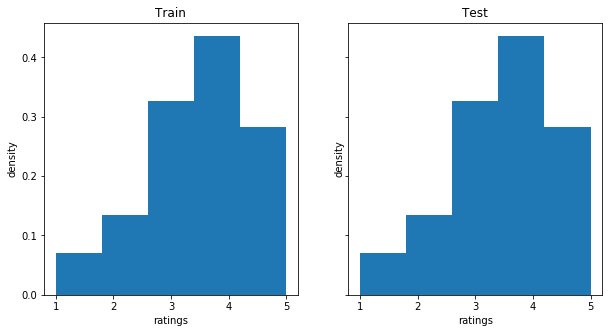

In [34]:
_, (ax1m, ax2m) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1m.hist(Xtr_1m[Xtr_1m !=0], 5, density= True)
ax1m.set_title('Train')
ax1m.set(xlabel="ratings", ylabel="density")
ax2m.hist(Xtst_1m[Xtst_1m !=0], 5, density= True)
ax2m.set_title('Test')
ax2m.set(xlabel="ratings", ylabel="density")

We now repeat the same operations for the other datasets

In [35]:
#100k
am100k = AffinityMatrix(DF = mldf_100k, **header)
X100k= am100k.gen_affinity_matrix()
Xtr_100k, Xtst_100k = numpy_stratified_split(X100k)

[Text(0, 0.5, 'density'), Text(0.5, 0, 'ratings')]

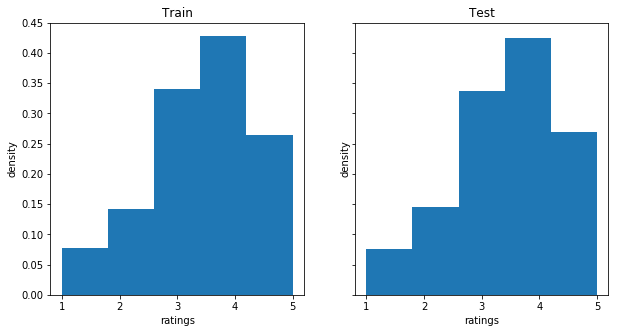

In [36]:
_, (ax1k, ax2k) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1k.hist(Xtr_100k[Xtr_100k !=0], 5, density= True)
ax1k.set_title('Train')
ax1k.set(xlabel="ratings", ylabel="density")
ax2k.hist(Xtst_100k[Xtst_100k !=0], 5, density= True)
ax2k.set_title('Test')
ax2k.set(xlabel="ratings", ylabel="density")

- 위의 그림에서 두 데이터 세트가 매우 유사한 등급 분포를 갖는 것을 볼 수 있습니다. 가장 큰 차이점은 사용자 / 항목 유사도 행렬의 희소성 정도입니다. 
- 이것은 유추할 데이터 포인트와 등급이 매겨지지 않은 영화의 비율을 나타내는 중요한 요소입니다. 분할 함수는 사용자 별이 아닌 총 (또는 데이터 세트 당) sparsness를 반환합니다.

In [37]:
#collection of evaluation metrics for later use
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

# 4. Model application, performance and analysis of the results  

- 해당 모델은 TF 세션이 fit() 방법 안에 숨겨져 있어 명시적인 호출이 필요하지 않도록 Tensorflow (TF) 클래스로 구현되었습니다. 알고리즘은 세 가지 단계로 작동합니다.


1) 모델 초기화 : 여기서 TF에게 계산 그래프를 만드는 방법을 알려줍니다. 지정할 주요 매개 변수는 숨겨진 단위의 수, 훈련 epochs 수 및 미니 배치 크기입니다.

2) 모델 적합: 데이터에서 모형을 훈련하는 곳입니다. 이 방법은 두 가지 arguments, 즉 훈련과 테스트 세트 행렬을 취합니다. 모델은 훈련 세트에서만 훈련되며, 테스트 세트는 훈련된 모델의 테스트 세트 정확도를 표시하는데 사용되며, 차례로 알고리즘의 생성 기능을 추정합니다. 일반적으로 최적화 동작에 대한 첫 번째 아이디어를 갖기 위해 이러한 양을 보는 것이 유용합니다.

3) 모델 예측: 여기서 보이지 않는 항목에 대한 등급을 생성합니다. 일단 모델이 훈련되고 전체적인 정확성에 만족하면 학습된 분포로부터 새로운 등급을 샘플링합니다. 특히, 우리는 top_k (예 :. 10) 사전 정의 된 점수에 따라 대부분의 관련 추천 사항. 다음 예측을 분석하고 배포할 준비가 된 데이터 프레임 형식으로 반환합니다.

## 4.1 1m Dataset

In [79]:
#First we initialize the model class
model_1m = RBM(hidden_units= 1200, training_epoch = 30, minibatch_size= 350, with_metrics=True, debug=True)

- fitting 방법을 처음 호출할 때 결과를 반환하는 데 더 오래 걸릴 수 있습니다. 이것은 TF가 GPU 세션을 초기화해야 한다는 사실 때문입니다. 
- 알고리즘을 두 번 이상 훈련할 때에는 그렇지 않다는 것을 알 수 있습니다. 미니배치 크기에 대해서는 합리적인 실행 시간을 지키면서 일반화 오류가 좋은 값을 선택하고 싶다. 
- 크기가 작을수록 확률적 기울기 하강에 가까워지지만 훈련은 더 오래 걸립니다. 큰 크기 값 (예 : 배치 크기의 1/2)은 훈련을 가속화하지만 일반화 오류를 증가시킵니다.

CD step 1
CD step 2
CD step 3
CD step 4
CD step 5


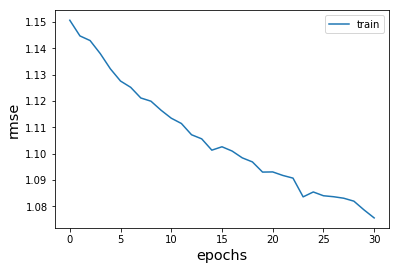

In [80]:
#Model Fit
train_time = model_1m.fit(Xtr_1m, Xtst_1m)

- 훈련하는 동안, 학습이 어떻게 진행되고 있는지에 대한 아이디어를 갖기 위해 root mean squared error 를 평가합니다. 
- RBM에서 최소화되는 양이 아니라, epoch 당 rmse를 플로팅하면 학습이 어떻게 진행되고 하이퍼 매개 변수를 어떻게 조정해야하는지에 대한 대략적인 이해를 얻을 수 있습니다. 
- 일반적으로 rmse가 학습 epochs의 함수로 단조롭게 감소하는 것을 보고 싶습니다. 
- 자동화된 하이퍼 파라미터 최적화 방법을 사용할 수는 있지만, 학습 프로세스를 수동으로 검사하는 데 시간을 할애할 것을 강력히 제안합니다. 
- 하이퍼 파라미터에 대해 기대할 수 있는 값 범위에 대한 아이디어를 제공합니다. 마지막으로, 대부분의 자동화된 하이퍼 매개 변수 검색 방법은 감독 학습에 최적화되어 있으므로 감독되지 않은 작업에도 잘 작동하지 않을 수 있습니다.

- 두 가지 최종 점수는 차이점과 함께 모든 세트에서 훈련 / 테스트 평균 정확도입니다. 이것은 다음과 같이 정의되었습니다.


$$ AC = \frac{1}{m} \sum_{\mu=1}^{m} \sum_{i=1}^{N_v} \frac{1}{s_i} \, I(v=vp)_{\mu,i}, $$

- m = 총 사용자 수, Nv = visible 단위의 총 수,행 당 0이 아닌 요소의 수, si = 사용자 별 총 등급 수
- 모델이 일반화되기 위해서는 훈련와 테스트 셋의 측정 기준의 차이가 너무 커서는 안된다는 점을 기억하라. 온라인 메트릭을 시각화하려면 RBM() 모델 함수에서 with_metrics = True를 선택합니다. 
- 측정 기준을 평가할 때 모형은 실행하는 데 조금 더 오래 걸리지만 작업의 탐색 단계에서만 실행해야 합니다

### 4.1.2 Model Evaluation

- 모델 성능을 평가하고 리포지토리의 다른 알고리즘과 비교하기 위해 recommend_k_items() 방법을 사용합니다. pandas 데이터 프레임 형식으로 올바른 사용자 / 항목 ID를 반환하기 위해 'maps'을 두 번째 인수로 전달합니다.

In [40]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k_1m, test_time =  model_1m.recommend_k_items(Xtst_1m)

In [42]:
top_k_1m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
test_time

1.9036312103271484

- top_k는 가장 높은 추천 점수를 가진 첫 번째 K 요소를 반환합니다. 
- 여기서 추천 점수는 예측된 등급에 확률을 곱하여 평가됩니다. 알고리즘이 출력에 대해 가지고 있는 신뢰 따라서 예측된 등급 5를 가진 두 항목을 모두 가지고 있지만 확률이 0.5이고 다른 항목이 0.9인 경우 후자는 더 관련이 있는 것으로 간주됩니다. 
- 예측을 검사하고 이 저장소에서 평가 메트릭을 사용하기 위해 up_k 및 Xtst를 모두 pandas 데이터 프레임 형식으로 변환합니다.

In [44]:
top_k_df_1m = am1m.map_back_sparse(top_k_1m, kind = 'prediction')
test_df_1m = am1m.map_back_sparse(Xtst_1m, kind = 'ratings')

In [48]:
top_k_df_1m[1:10]

,movieID,prediction,userID
1,1,4.999514,1
2,1029,4.996136,1
3,2028,4.991727,1
4,2355,4.996497,1
5,1270,4.996549,1
6,271,4.988898,1
7,1324,4.986278,1
8,758,4.984018,1
9,584,4.990669,1


In [49]:
test_df_1m[1:10]

,movieID,rating,userID
1,588,4,1
2,1836,5,1
3,1,5,1
4,1962,4,1
5,1029,5,1
6,2028,5,1
7,1961,5,1
8,2355,5,1
9,2321,3,1


In [50]:
rating_1m= ranking_metrics(
    data_size = "mv 1m",
    data_true =test_df_1m,
    data_pred =top_k_df_1m,
    time_train=train_time,
    time_test =test_time,
    K =10)

rating_1m

,Dataset,K,MAP,Precision@k,Recall@k,Test time (s),Train time (s),nDCG@k
0,mv 1m,10,0.279546,0.590629,0.320554,1.903631,48.519701,0.691484


- 공식적으로, 비용 함수가 평평해질 때까지 모델을 훈련시켜야 하지만 종종 "early stopping"의 작업을 수행합니다. 위의 예에서 우리는 알고리즘을 훈련시켜 상위 순위 메트릭을 달성하기로 결정했습니다. 더 빠른 최적화도 가능하지만 순위 측정 기준은 감소합니다.

## 4.2 100k Dataset

In [51]:
#100k
model_100k = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60,keep_prob= 0.9, with_metrics = True)

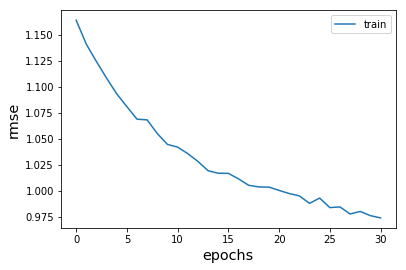

In [52]:
train_time = model_100k.fit(Xtr_100k, Xtst_100k)

In [53]:
#Model prediction on the test set Xtst. 
top_k_100k, test_time =  model_100k.recommend_k_items(Xtst_100k)

#to df
top_k_df_100k = am100k.map_back_sparse(top_k_100k, kind = 'prediction')
test_df_100k = am100k.map_back_sparse(Xtst_100k, kind = 'ratings')

### 4.2.1 Model evaluation 

In [54]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df_100k,
    data_pred =top_k_df_100k,
    time_train=train_time,
    time_test =test_time,
    K=10) 

eval_100k

,Dataset,K,MAP,Precision@k,Recall@k,Test time (s),Train time (s),nDCG@k
0,mv 100k,10,0.167566,0.421527,0.249489,0.281705,7.322173,0.491173
